# MAxCut solved with QAOA on QISKIT: Noise Model + Mitiq ZNE + OpenQAOA

In [3]:
from __future__ import annotations

Let's define the input graph for the MaxCut

In [4]:
import numpy as np
import networkx as nx

num_nodes = 4
w = np.array([[0., 1., 1., 0.],
              [1., 0., 1., 1.],
              [1., 1., 0., 1.],
              [0., 1., 1., 0.]])
G = nx.from_numpy_array(w)

Let's represent the graph

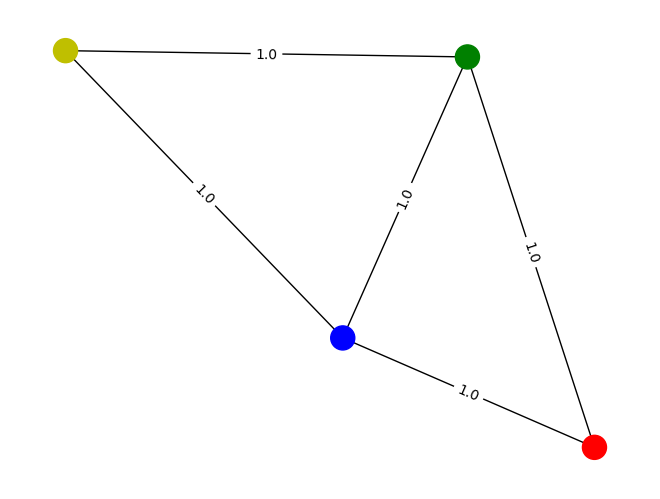

In [5]:
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

Utilities to solve the problem classically via brute-forcing

In [6]:
def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)

def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

# use the brute-force way to generate the oracle
L = num_nodes
max = 2**L
sol = np.inf
for i in range(max):
    cur = bitfield(i, L)

    how_many_nonzero = np.count_nonzero(cur)
    if how_many_nonzero * 2 != L:  # not balanced
        continue

    cur_v = objective_value(np.array(cur), w)
    if cur_v < sol:
        sol = cur_v

print(f'Objective value computed by the brute-force method is {sol}')

Objective value computed by the brute-force method is 3


Let's build the quantum circuit

In [7]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

qc_mix.draw()

/tmp/ipykernel_144828/3998253988.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


┌───────────────┐
q_0: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_1: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_2: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_3: ┤ Rx(2*$\beta$) ├
     └───────────────┘

In [8]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw()

░                              ░      »
q_0: ──■──────────────────────■───░───■──────────────────────■───░──────»
     ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░      »
q_1: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───■──»
     └───┘└────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ ┌─┴─┐»
q_2: ─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─┤ X ├»
                                  ░ └───┘└────────────────┘└───┘ ░ └───┘»
q_3: ─────────────────────────────░──────────────────────────────░──────»
                                  ░                              ░      »
«                             ░                              ░      »
«q_0: ────────────────────────░──────────────────────────────░──────»
«                             ░                              ░      »
«q_1: ────────────────────■───░───■──────────────────────■───░──────»
«     ┌────────────────┐┌─┴─┐ ░   │                      │   ░      »
«q_2: ┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───■──»
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ ┌─┴─┐»
«q_3: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─┤ X ├»
«                             ░ └───┘└────────────────┘└───┘ ░ └───┘»
«                             ░ 
«q_0: ────────────────────────░─
«                             ░ 
«q_1: ────────────────────────░─
«                             ░ 
«q_2: ────────────────────■───░─
«     ┌────────────────┐┌─┴─┐ ░ 
«q_3: ┤ Rz(2*$\gamma$) ├┤ X ├─░─
«     └────────────────┘└───┘ ░

In [9]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

qc_0.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘

In [10]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

┌─────────┐┌────────────────┐                             ░      »
q_0: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├──■──────────────────────■───░───■──»
     ├─────────┤├────────────────┤┌─┴─┐┌────────────────┐┌─┴─┐ ░   │  »
q_1: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──»
     ├─────────┤├────────────────┤└───┘└────────────────┘└───┘ ░ ┌─┴─┐»
q_2: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─────────────────────────────░─┤ X ├»
     ├─────────┤├────────────────┤                             ░ └───┘»
q_3: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─────────────────────────────░──────»
     └─────────┘└────────────────┘                             ░      »
«                             ░                              ░      »
«q_0: ────────────────────■───░──────────────────────────────░──────»
«                         │   ░                              ░      »
«q_1: ────────────────────┼───░───■──────────────────────■───░───■──»
«     ┌────────────────┐┌─┴─┐ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │  »
«q_2: ┤ Rz(2*$\gamma$) ├┤ X ├─░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──»
«     └────────────────┘└───┘ ░ └───┘└────────────────┘└───┘ ░ ┌─┴─┐»
«q_3: ────────────────────────░──────────────────────────────░─┤ X ├»
«                             ░                              ░ └───┘»
«                             ░                              ░ 
«q_0: ────────────────────────░──────────────────────────────░─
«                             ░                              ░ 
«q_1: ────────────────────■───░──────────────────────────────░─
«                         │   ░                              ░ 
«q_2: ────────────────────┼───░───■──────────────────────■───░─
«     ┌────────────────┐┌─┴─┐ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ 
«q_3: ┤ Rz(2*$\gamma$) ├┤ X ├─░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─
«     └────────────────┘└───┘ ░ └───┘└────────────────┘└───┘ ░

Let's import Mitiq 

In [41]:
from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne import execute_with_zne
from mitiq.zne.scaling import (
    fold_gates_at_random,
    fold_global,
    fold_all
)
from mitiq.zne.inference import LinearFactory, RichardsonFactory
from mitiq import (
    Calibrator,
    Settings,
    execute_with_mitigation,
    MeasurementResult,
)

from mitiq.zne import mitigate_executor

Let's define a noise model

In [18]:
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

In [20]:
from qiskit_aer import AerSimulator
noisy_backend = AerSimulator(noise_model=noise_bit_flip)

Let's define some utility functions

In [31]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.

    Args:
        x: str
           solution bitstring

        G: networkx graph

    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1

    return obj


def compute_expectation(counts, G):

    """
    Computes expectation value based on measurement results

    Args:
        counts: dict
                key as bitstring, val as count

        G: networkx graph

    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count

    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):

    """
    Creates a parametrized qaoa circuit

    Args:
        G: networkx graph
        theta: list
               unitary parameters

    Returns:
        qc: qiskit circuit
    """

    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)

    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)

    for irep in range(0, p):

        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

    qc.measure_all()

    return qc


from qiskit import Aer

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512, backend=Aer.get_backend('aer_simulator')):

    """
    Runs parametrized circuit

    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    #backend = Aer.get_backend('aer_simulator')

    def execute_circ(theta):

        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, shots=512).result().get_counts()

        return compute_expectation(counts, G)

    return execute_circ

Let's perform the minimization

In [23]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation,
                      [1.0, 1.0],
                      method='COBYLA')

Let's see the results without noise

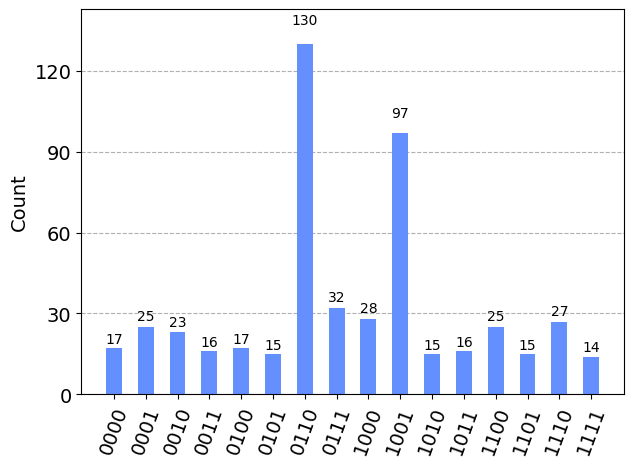

In [24]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(G, res.x)

counts = Aer.get_backend('aer_simulator').run(qc_res, shots=512).result().get_counts()

plot_histogram(counts)

Let's do it again with noise

In [26]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1, backend=noisy_backend)

res = minimize(expectation,
                      [1.0, 1.0],
                      method='COBYLA')

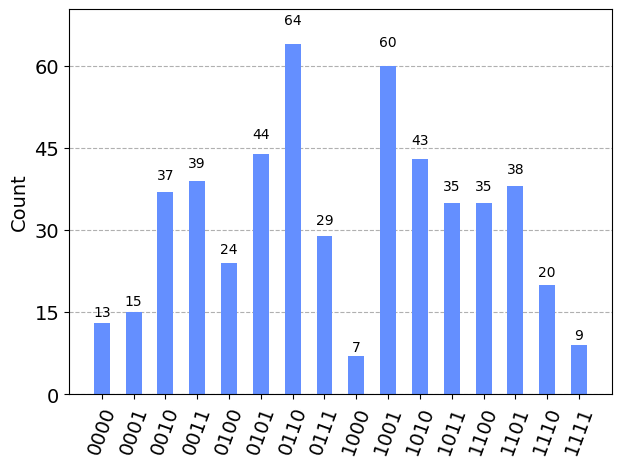

In [27]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(G, res.x)

counts = noisy_backend.run(qc_res, shots=512).result().get_counts()

plot_histogram(counts)

Let's apply Mitiq

In [57]:
def execute_circuit(circuit, p=0.05):
    """Execute the input circuit and return the expectation value of |00..0><00..0|"""
    noisy_result = noisy_backend.run(circuit, shots=512).result()
    noisy_counts = noisy_result.get_counts(circuit)
    noisy_expectation_value = noisy_counts[4 * "0"] / 512
    return noisy_expectation_value

def zne_callable(graph, noise_level=0,shots=512):
    def execute_circ(qc):
        return execute_circuit(qc)
    return execute_circ

In [59]:
expectation = execute_circuit(create_qaoa_circ(G, res.x))
    
#create the ZNE mitigated expectation(executor)
fac = RichardsonFactory(scale_factors=[1, 3, 5])
mitigated_expectation = mitigate_executor(executor=zne_callable,factory=fac)


qc = create_qaoa_circ(G, res.x)
print(type(qc))
#cost_function = execute_with_zne(qc, execute_circuit)
#output = minimize(cost_function,[1.0,1.0],method = 'COBYLA')
#output

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


Let's now use OpenQAOA

In [ ]:
from openqaoa.problems import MaximumCut

maxcut_prob = MaximumCut(G)
maxcut_qubo = maxcut_prob.qubo

In [ ]:
maxcut_qubo.hamiltonian.expression


Let's apply some customization parameters

In [ ]:
maxcut_qubo.asdict()
q = QAOA()
# circuit properties
q.set_circuit_properties(p=3, param_type='standard', init_type='ramp', mixer_hamiltonian='xy')

# backend properties
q.set_backend_properties(init_hadamard=True, n_shots=8000, cvar_alpha=0.85)

# classical optimizer properties
q.set_classical_optimizer(method='cobyla', maxiter=50, tol=0.05)

Let's solve the problem

In [ ]:
q.compile(maxcut_qubo)
q.optimize()

In [ ]:
results = q.result
print('Most probable states:', results.most_probable_states['solutions_bitstrings'])
results.plot_probabilities()